In [187]:
from typing import List
from math import sqrt, exp
from scipy.special import expit
from scipy.integrate import trapz
import statistics as st
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('./hw3Data/D2z.txt', sep='\s+', names=['x1', 'x2', 'y'])
df

,x1,x2,y
0,-0.333338,-0.087171,0
1,-1.531730,0.358194,1
2,1.549590,-0.364050,0
3,-1.349910,0.252063,1
4,1.283850,-0.531146,0
...,...,...,...
195,-0.697750,1.098280,1
196,1.161160,-0.733751,0
197,-1.288480,0.443773,1
198,-1.384200,0.526523,1


In [43]:
def distance_Euclidean(X1: pd.Series, X2: pd.Series) -> float:
    d = 0
    for i in range(0, len(X1)):
        d += (X1[i] - X2[i])**2
    d = math.sqrt(d)
    return d

def kNN(train: pd.DataFrame, sample: pd.Series, label: str, k: int) -> int:
    # compute distances
    distances = []
    for i, row in train.iterrows():
        distance = distance_Euclidean(sample, row.drop(label))
        distances.append((i, distance))
    distances.sort(key=lambda x: x[1])
    # tally the votes for the k-nearest
    votes = []
    for d in distances[:k]:
        vote = train.iloc[d[0]][label]
        votes.append(vote)
    # determine the prediction
    majority = pd.Series(votes).mode()
    if len(majority) > 1:
        return votes[0]
    else:
        return majority[0]

In [30]:
data_range = np.arange(-2, 2.1, 0.1)
df1 = pd.DataFrame({'x': data_range})
df2 = pd.DataFrame({'y': data_range})
test_df = df1.merge(df2, how='cross')
test_df

,x,y
0,-2.0,-2.0
1,-2.0,-1.9
2,-2.0,-1.8
3,-2.0,-1.7
4,-2.0,-1.6
...,...,...
1676,2.0,1.6
1677,2.0,1.7
1678,2.0,1.8
1679,2.0,1.9


In [31]:
predictions = []
for i, row in test_df.iterrows():
    predictions.append(kNN(df, row, 'y', 1))
test_df['predicted_class'] = predictions

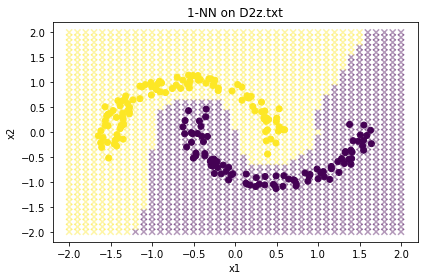

In [32]:
plt.scatter(x=test_df['x'], y=test_df['y'], c=test_df['predicted_class'], cmap='viridis', alpha=0.4, marker='x')
plt.scatter(x=df['x1'], y=df['x2'], c=df['y'], cmap='viridis', alpha=1, marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('1-NN on D2z.txt')
plt.tight_layout()
plt.show()

In [3]:
emails_df = pd.read_csv('./hw3Data/emails.csv').drop('Email No.', axis=1).reset_index()
emails = np.array(emails_df)

In [4]:
emails[100][1:-1].shape

(3000,)

In [83]:
distance_matrix = []
for i in range(len(emails)):
    X1 = emails[i][1:-1]
    distances = []
    for j in range(len(emails)):
        X2 = emails[j][1:-1]
        d = sqrt(np.sum((X2 - X1)**2))
        distances.append((j, sqrt(d)))
    distances.sort(key=lambda x: x[1])
    distance_matrix.append(distances)
distance_matrix = np.array(distance_matrix)

In [153]:
def cross_validate(begin: int, end: int, k: int) -> (float, float, float):
    fold = np.array(emails[begin:end])
    predicted_labels = []
    for row in fold:
        index = row[0]
        distance_matrix[index]
        neighbors = [x for x in distance_matrix[index][:, 0] if x < begin or x >= end][:k]
        votes = [emails[int(neighbor)][-1] for neighbor in neighbors]
        plurality = st.mode(votes)
        predicted_labels.append(plurality)

    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(predicted_labels)):
        predicted_class = predicted_labels[i]
        true_class = fold[i][-1]
        if predicted_class == 1:
            if true_class == 1:
                TP += 1
            elif true_class == 0:
                FP += 1
        elif predicted_class == 0:
            if true_class == 1:
                FN += 1
            elif true_class == 0:
                TN += 1

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return accuracy, precision, recall

In [154]:
# 5-fold k=1
results = []
results.append(cross_validate(0, 1000, 1))
results.append(cross_validate(1000, 2000, 1))
results.append(cross_validate(2000, 3000, 1))
results.append(cross_validate(3000, 4000, 1))
results.append(cross_validate(4000, 5000, 1))
accuracies = [x[0] for x in results]
precisions = [x[1] for x in results]
recalls = [x[2] for x in results]

In [155]:
print(accuracies)
print(precisions)
print(recalls)

[0.825, 0.853, 0.862, 0.851, 0.775]
[0.6544943820224719, 0.6857142857142857, 0.7212121212121212, 0.7164179104477612, 0.6057441253263708]
[0.8175438596491228, 0.8664259927797834, 0.8380281690140845, 0.8163265306122449, 0.7581699346405228]


In [156]:
avg_accuracies = []
k_range = [1, 3, 5, 7, 10]
for k in k_range:
    accuracies = []
    accuracies.append(cross_validate(0, 1000, k)[0])
    accuracies.append(cross_validate(1000, 2000, k)[0])
    accuracies.append(cross_validate(2000, 3000, k)[0])
    accuracies.append(cross_validate(3000, 4000, k)[0])
    accuracies.append(cross_validate(4000, 5000, k)[0])
    avg_accuracies.append(st.mean(accuracies))

In [157]:
print(avg_accuracies)

[0.8331999999999999, 0.8424, 0.8418, 0.8454, 0.849]


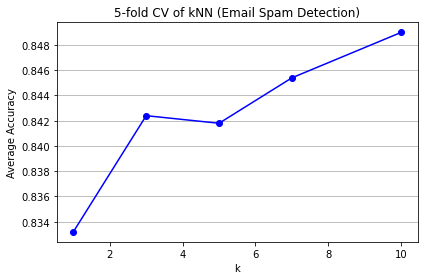

In [163]:
plt.plot(k_range, avg_accuracies, 'ob-')
plt.title('5-fold CV of kNN (Email Spam Detection)')
plt.xlabel('k')
plt.ylabel('Average Accuracy')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

In [177]:
def gradient_descent(X: np.ndarray, Y: np.ndarray, learning_rate: float, epochs: int) -> np.ndarray:
    # we expect every x in X to have its first feature be 1 (bias)
    a = learning_rate
    W = np.zeros(X.shape[1])
    size = len(X)

    for i in range(epochs):
        sigmoid_vector = expit(X @ W)
        grad = X.T @ (sigmoid_vector - Y)
        W -= a * grad / size
    return W
# def gradient_descent(X: np.ndarray, Y: np.ndarray, learning_rate: float, epochs: int) -> np.ndarray:
#     # we expect every x in X to have its first feature be 1 (bias)
#     a = learning_rate
#     W = np.zeros(X.shape[1])

#     for i in range(epochs):
#         sigmoid_vector = []
#         for j in range(len(X)):
#             sigmoid_vector.append(expit(X[j] @ W[j]))
#         sigmoid_vector = expit(X @ W)
#         grad = X.T @ (sigmoid_vector - Y)
#         W -= a * grad
#     return W

In [144]:
def logistic_predict(W: np.ndarray, X: np.ndarray, Y: np.ndarray, threshold: float) -> (float, float, float):
    TP, TN, FP, FN = 0, 0, 0, 0
    sigma = expit(X @ W)
    yhat = [1 if s >= threshold else 0 for s in sigma]
    for i in range(len(Y)):
        y = Y[i]
        yp = yhat[i]
        if y == 1:
            if yp == 1:
                TP += 1
            elif yp == 0:
                FN += 1
        elif y == 0:
            if yp == 1:
                FP += 1
            elif yp == 0:
                TN += 1
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return accuracy, precision, recall

In [71]:
emails_df = pd.read_csv('./hw3Data/emails.csv').drop('Email No.', axis=1).reset_index()
emails = np.array(emails_df)

X = np.array(emails[:, :-1])
X[:, 0] = np.ones(len(X)) # replace index with 1 for bias
Y = np.array(emails[:, -1])

In [77]:
learn_rate = 0.001
num_epochs = 3000
threshold = 0.5
results = []

f1W = gradient_descent(X[1000:5000], Y[1000:5000], learn_rate, num_epochs)
results.append(logistic_predict(f1W, X[0:1000], Y[0:1000], threshold))

f2W = gradient_descent(X[np.r_[0:1000, 2000:5000]], Y[np.r_[0:1000, 2000:5000]], learn_rate, num_epochs)
results.append(logistic_predict(f2W, X[1000:2000], Y[1000:2000], threshold))

f3W = gradient_descent(X[np.r_[0:2000, 3000:5000]], Y[np.r_[0:2000, 3000:5000]], learn_rate, num_epochs)
results.append(logistic_predict(f3W, X[2000:3000], Y[2000:3000], threshold))

f4W = gradient_descent(X[np.r_[0:3000, 4000:5000]], Y[np.r_[0:3000, 4000:5000]], learn_rate, num_epochs)
results.append(logistic_predict(f4W, X[3000:4000], Y[3000:4000], threshold))

f5W = gradient_descent(X[0:4000], Y[0:4000], learn_rate, num_epochs)
results.append(logistic_predict(f5W, X[4000:5000], Y[4000:5000], threshold))

accuracies = [x[0] for x in results]
precisions = [x[1] for x in results]
recalls = [x[2] for x in results]

<ipython-input-61-8a45400b48c9>:7: RuntimeWarning: overflow encountered in exp
  sigmoid_vector = 1 / (1 + np.exp(-(X @ W)))
<ipython-input-70-6e56ccb34b8e>:3: RuntimeWarning: overflow encountered in exp
  sigma = 1 / (1 + np.exp(-(X @ W)))


In [78]:
print(accuracies)
print(precisions)
print(recalls)

[0.929, 0.866, 0.921, 0.93, 0.908]
[0.9053030303030303, 0.9440993788819876, 0.9083665338645418, 0.8758389261744967, 0.8639455782312925]
[0.8385964912280702, 0.5487364620938628, 0.8028169014084507, 0.8877551020408163, 0.8300653594771242]


In [82]:
# single training/test
# kNN (k=5) vs logistic regression
# plot ROC
emails_df = pd.read_csv('./hw3Data/emails.csv').drop('Email No.', axis=1).reset_index()
emails = np.array(emails_df)

In [85]:
def fiveNN_confidence(begin: int, end: int, threshold: int) -> (float, float):
    k = 5
    fold = np.array(emails[begin:end])
    predicted_labels = []
    for row in fold:
        index = row[0]
        distance_matrix[index]
        neighbors = [x for x in distance_matrix[index][:, 0] if x < begin or x >= end][:k]
        votes = [emails[int(neighbor)][-1] for neighbor in neighbors]
        ones = np.sum(votes)
        predicted_labels.append(1 if ones >= threshold else 0)

    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(predicted_labels)):
        predicted_class = predicted_labels[i]
        true_class = fold[i][-1]
        if predicted_class == 1:
            if true_class == 1:
                TP += 1
            elif true_class == 0:
                FP += 1
        elif predicted_class == 0:
            if true_class == 1:
                FN += 1
            elif true_class == 0:
                TN += 1

    TPR = TP / (TP + FN)
    FPR = FP / (TN + FP)
    return TPR, FPR

In [86]:
kNN_results = []
for i in [0, 1, 2, 3, 4, 5]:
    kNN_results.append(fiveNN_confidence(4000, 5000, i))
kNN_results

[(1.0, 1.0),
 (0.9607843137254902, 0.5072046109510087),
 (0.8856209150326797, 0.3314121037463977),
 (0.7483660130718954, 0.207492795389049),
 (0.5686274509803921, 0.10662824207492795),
 (0.3562091503267974, 0.056195965417867436)]

In [132]:
emails_df = pd.read_csv('./hw3Data/emails.csv').drop('Email No.', axis=1).reset_index()
emails = np.array(emails_df)

X = np.array(emails[:, :-1])
X[:, 0] = np.ones(len(X)) # replace index with 1 for bias
Y = np.array(emails[:, -1])

In [139]:
def logreg_confidence(W: np.ndarray, X: np.ndarray, Y: np.ndarray, threshold: float) -> (float, float):
    TP, TN, FP, FN = 0, 0, 0, 0
    sigma = expit(X @ W)
    yhat = [1 if s >= threshold else 0 for s in sigma]
    for i in range(len(Y)):
        y = Y[i]
        yp = yhat[i]
        if y == 1:
            if yp == 1:
                TP += 1
            elif yp == 0:
                FN += 1
        elif y == 0:
            if yp == 1:
                FP += 1
            elif yp == 0:
                TN += 1
    TPR = TP / (TP + FN)
    FPR = FP / (TN + FP)
    return TPR, FPR

In [183]:
W = gradient_descent(X[0:4000], Y[0:4000], 0.001, 3000)

In [184]:
logReg_results = []
for i in np.linspace(0, 1, 100):
    logReg_results.append(logreg_confidence(W, X[4000:5000], Y[4000:5000], i))

In [164]:
#expit((X @ W))
#1 / (1 + np.exp(-(X @ W)))

array([0., 0., 0., ..., 0., 0., 0.])

In [185]:
for w in W:
    print(w)

-0.024681836366224747
-0.06563926384870895
-0.05674720445934898
-0.10286351038977595
-0.01718966958309461
-0.09522836537412557
0.09736081621902763
-0.02449830131364133
0.014047320960202263
-0.05431940852355666
-0.01096331983453378
-0.100344121568274
0.005011661650927743
-0.0158757536198494
-0.16630496206396866
0.0715830532103677
-0.0222679973682575
0.0048315883634615555
-0.09102010379801861
-0.045171208170548635
0.019468509997187793
0.008274988665793868
-0.039654110293804036
-0.026464207858947836
0.010564772464744871
-0.03837043852057893
0.03679489648863186
-0.01768342302231687
-0.005573493169433374
-0.09039106642460963
-0.026174681258768494
-0.07543495529637659
-0.03129167463184468
0.02159672275118686
-0.034833901068821685
-0.06601987157026849
-0.0698671419802394
-0.059393545881237554
-0.15398540119767115
-0.06441928249505739
0.12473997729035077
-0.047108807926250586
-0.004600580885115378
0.011272034366444502
-0.0291709275749047
0.00283282872578741
0.02982687305087621
0.00603049175806

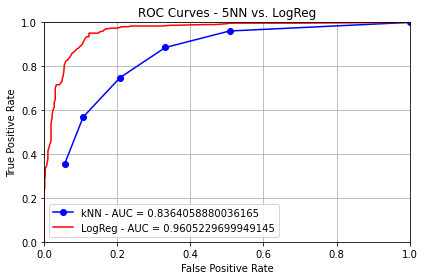

In [189]:
kNN_TPRs = [result[0] for result in kNN_results]
kNN_FPRs = [result[1] for result in kNN_results]

logReg_TPRs = [result[0] for result in logReg_results]
logReg_FPRs = [result[1] for result in logReg_results]

kNN_auc = round(-trapz(kNN_TPRs, kNN_FPRs), 3)
logReg_auc = round(-trapz(logReg_TPRs, logReg_FPRs), 3)

plt.plot(kNN_FPRs, kNN_TPRs, 'ob-', label='kNN - AUC = ' + str(kNN_auc))
plt.plot(logReg_FPRs, logReg_TPRs, 'r-', label='LogReg - AUC = ' + str(logReg_auc))
plt.title('ROC Curves - 5NN vs. LogReg')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(which='both', axis='both')
plt.xticks([i/5 for i in range(6)])
plt.yticks([i/5 for i in range(6)])
plt.legend()
plt.tight_layout()
plt.show()